# Visualization of results


### How to use
First, you must set the environment variables `MONGODB_USER`, `MONGODB_PASSWORD`, and `MONGODB_HOST` to point to your database. 

We use a simple filter & group interface: 
- you can define config options which MUST be present in all runs and filter for them (e.g., `filter_by = {"attack": "gcg", "attack_params": {"num_steps": 250}}` for GCG runs with 250 steps)
- you can define config options to COMPARE, for example `group_by = {"model", ("attack_params", "token_selection")}` to compare across different models and `attack_params.token_selection` strategies


In [69]:
import json
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from src.io_utils import get_mongodb_connection

def check_match(doc_fragment, filter_fragment):
    """
    Recursively checks if a part of a document matches a filter structure.

    Args:
        doc_fragment: The part of the document (dict, list, or primitive) to check.
        filter_fragment: The corresponding part of the filter (dict, list, or primitive).

    Returns:
        bool: True if they match according to the filter logic, False otherwise.
    """
    if isinstance(filter_fragment, dict):
        # If filter is a dict, doc must also be a dict and all keys in filter must match
        if not isinstance(doc_fragment, dict):
            return False
        # Check if all keys/values specified in the filter dict match recursively
        for key, value in filter_fragment.items():
            if key not in doc_fragment:
                return False
            if not check_match(doc_fragment[key], value):
                return False
        return True  # All filter keys matched
    return doc_fragment == filter_fragment

def get_nested_value(data, path, default="unknown"):
    """
    Safely retrieves a value from a nested dictionary using a path list/tuple.

    Args:
        data (dict): The dictionary to search within.
        path (list or tuple): A list/tuple of keys representing the path.
        default: The value to return if the path is invalid or value not found.

    Returns:
        The value found at the path, or the default value.
    """
    current = data
    for key in path:
        if isinstance(current, dict) and key in current:
            current = current[key]
        else:
            return default # Path doesn't exist or intermediate element isn't a dict
    return current

def get_filtered_and_grouped_paths(filter_by, group_by) -> dict[tuple[str], list[str]]:
    """
    Retrieves log paths from MongoDB filtered by criteria and grouped according to group_by.

    Args:
        filter_by (dict): Filtering criteria. Can contain nested dictionaries.
        group_by (list or tuple): List/tuple of keys to group by from the 'config' field.

    Returns:
        dict: A dictionary where keys are group identifiers (tuples of strings)
              and values are lists of log paths.
    """
    # Connect to MongoDB
    db = get_mongodb_connection()
    collection = db.runs

    # Use MongoDB's find() method to get all documents
    all_results = list(collection.find())

    # Filter in Python using the check_match helper for complex nested conditions
    if filter_by:
        filtered_results = [
            doc for doc in all_results
            if check_match(doc['config'], filter_by)
        ]
    else:
        filtered_results = all_results

    # --- Grouping ---
    if not group_by:
        return {("all",): [r["log_file"] for r in filtered_results if "log_file" in r]}

    grouped_results = {}
    for result in filtered_results:
        # Ensure the result has 'config' and 'log_file' before processing
        if "config" not in result or "log_file" not in result:
            continue  # Skip records missing essential fields

        config_data = result["config"]
        log_path = result["log_file"]

        # Create a group key based on the specified group_by fields
        group_key_parts = []
        for key_spec in group_by:
            if isinstance(key_spec, str):
                value = get_nested_value(config_data, [key_spec])
                group_key_parts.append(f"{key_spec}={value}")
            elif isinstance(key_spec, (list, tuple)):
                value = get_nested_value(config_data, key_spec)
                key_name = '.'.join(map(str, key_spec))  # Ensure sub-keys are strings for join
                group_key_parts.append(f"{key_name}={value}")
            else:
                group_key_parts.append(f"invalid_group_spec={key_spec}")

        # Use a tuple of sorted key parts for consistent group keys
        group_key_tuple = tuple(sorted(group_key_parts))

        # Add the log path to the appropriate group
        if group_key_tuple not in grouped_results:
            grouped_results[group_key_tuple] = []
        grouped_results[group_key_tuple].append(log_path)
    return grouped_results

def collect_results(paths) -> dict[tuple[str], dict[str, list[float]]]:
    all_results = {}
    for k, v in paths.items():
        aggregated_results = defaultdict(list)
        for path in v:
            with open(path, "r") as f:
                results = json.load(f)
            for run in results["runs"]:
                collected_metrics = defaultdict(list) # {"loss": [1, 0.5, 0.3]}
                for step in run["steps"]:
                    for metric in step.keys():
                        collected_metrics[metric].append(step[metric])
                for metric, v in collected_metrics.items():
                    aggregated_results[metric].append(v)
        all_results[k] = aggregated_results
    return all_results

def plot_metric(results, metrics, verbose=False):
    # Create a figure with subplots - one for each metric
    n_metrics = len(metrics)
    fig, axes = plt.subplots(n_metrics, 1, figsize=(15, 6*n_metrics), squeeze=False)
    axes = axes.flatten()  # Flatten to easily iterate over axes

    # Define a color palette for consistent colors across groups
    colors = plt.cm.tab10.colors

    # Plot each metric in its own subplot
    for i, metric in enumerate(metrics):
        ax = axes[i]  # Get the current subplot

        for idx, (group_key, group_results) in enumerate(results.items()):

            if metric in group_results:
                # Get color for this group
                color = colors[idx % len(colors)]
                # Calculate mean and std for each step across runs
                metric_values = group_results[metric]
                # Make sure all sequences have the same length
                min_length = min(len(seq) for seq in metric_values)
                aligned_values = [seq[:min_length] for seq in metric_values]
                if verbose:
                    print(group_key, metric, len(aligned_values))
                # Create array for steps
                x = np.array(range(1, min_length + 1))

                # Calculate mean values for the main line
                mean_values = np.mean(aligned_values, axis=0)

                # Plot the mean line with the group's color
                ax.plot(x, mean_values, label=str(group_key), color=color)
            else:
                print(f"Metric {metric} not found for group {group_key}")

        # Set labels and title for each subplot
        ax.set_xlabel('Step')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'{metric.capitalize()}')
        ax.grid(True, linestyle='--', alpha=0.7)

        # Add legend to each subplot
        ax.legend()

    # Add space between subplots and adjust layout
    plt.subplots_adjust(wspace=0.3)
    plt.tight_layout()
    plt.show()

def make_plot(filter_by, group_by, metrics):
    paths = get_filtered_and_grouped_paths(filter_by, group_by)
    results = collect_results(paths)
    plot_metric(results, metrics, verbose=False)

In [61]:
filter_by = {}
group_by = {}
metrics = {}

In [71]:
# which attributes do you want to filter by?
filter_by = {"attack": "gcg", "attack_params": {"num_steps": 250, "generation_config": {"num_return_sequences": 1}}}
# which attributes do you want to compare/group by?
group_by = {"model", ("attack_params", "token_selection")}
metrics = ["loss", "time_taken"]

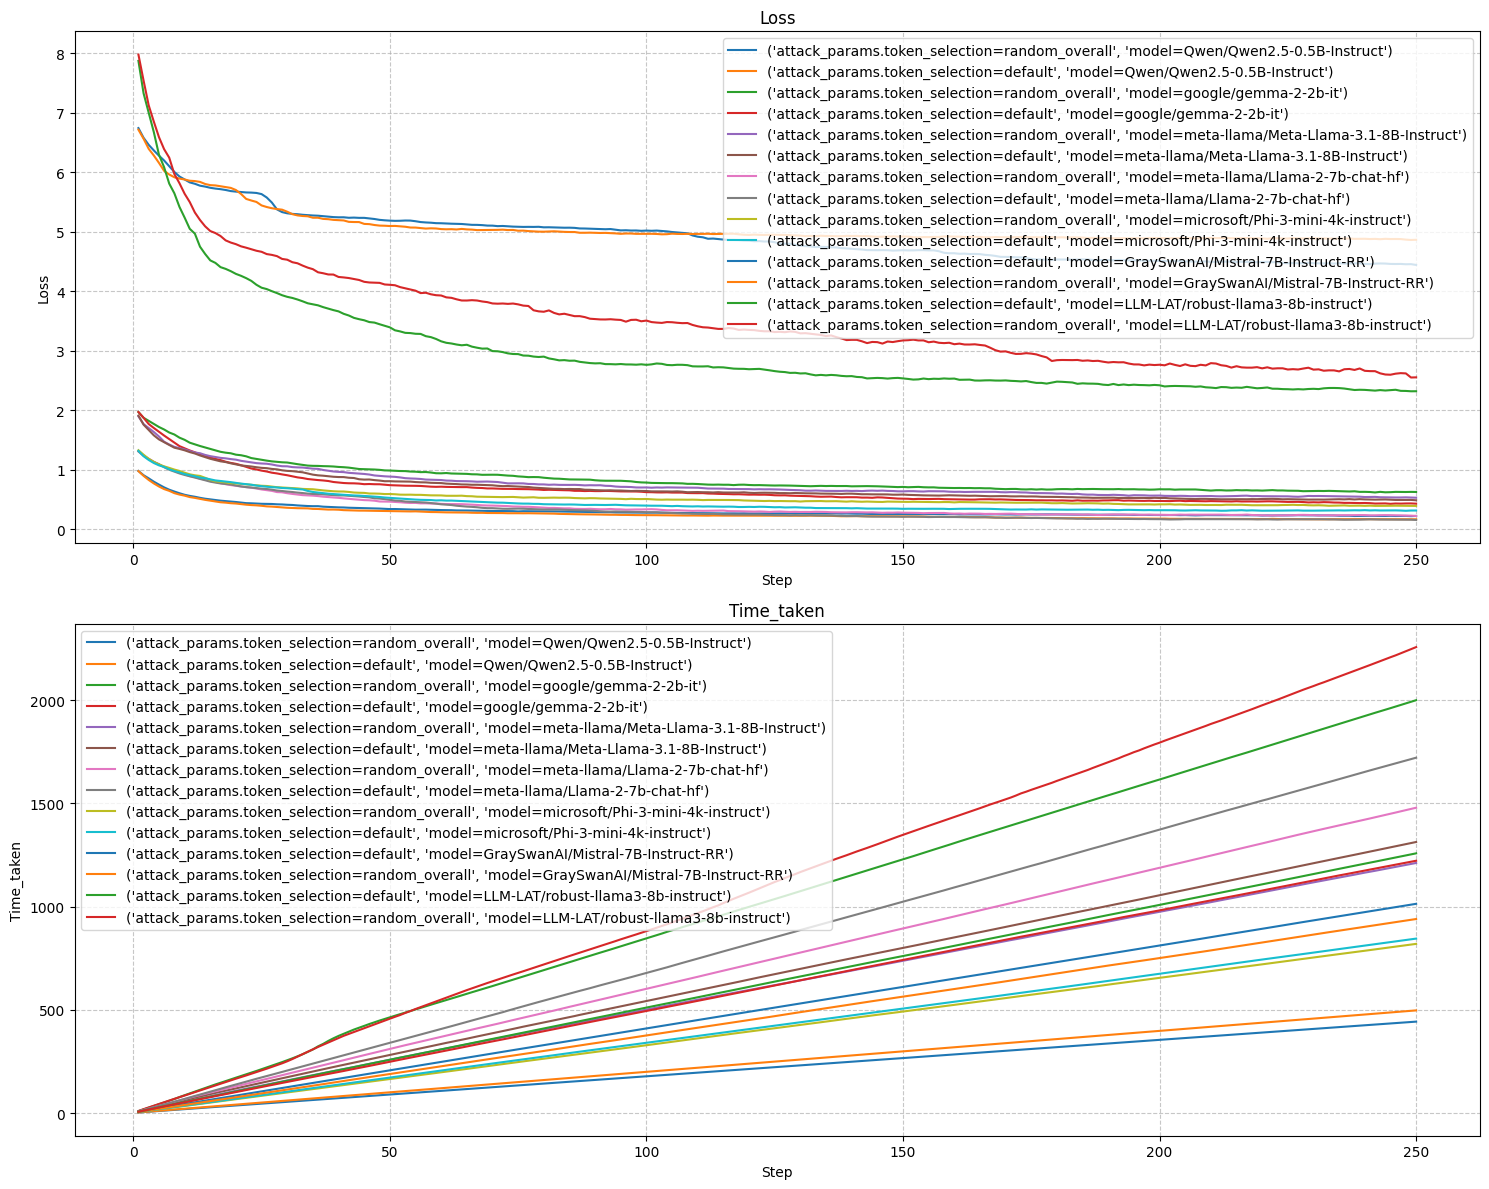

In [72]:
make_plot(filter_by, group_by, metrics)